In [1]:
import h5py
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import collections
from matplotlib import image
 
import matplotlib.animation as animation;
    
from math import *;

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy')  
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\BioHeatCpp\\PBHEswig\\x64')
import ablation_utils
import geom
import sonalleve
import transducers
import PBHEswig
from countlines import countlines

import imagemanip as imp;


%matplotlib inline

In [2]:
#h5name = "C:\\Users\\Vandiver\\Data\\simulations\\circ_nfoc\\nfoci_movingring_d=8mm.hdf5"
#h5name = "C:\\Users\\Vandiver\\Data\\simulations\\circ_nfoc\\nfoci_circ_triangle_d=3.5mm.hdf5"
h5name = "C:\\Users\\Vandiver\\Data\\simulations\\circ_d=3.5_I=1000.hdf5"
#h5name = "C:\\Users\\Vandiver\\Data\\simulations\\test.hdf5"
f = h5py.File(h5name, "r")

In [10]:
f.close()
del f

In [3]:
list(f['geom'].items())

[('ROIOFF', <HDF5 dataset "ROIOFF": shape (70, 70, 70), type "|b1">),
 ('ROION', <HDF5 dataset "ROION": shape (70, 70, 70), type "|b1">),
 ('gridx', <HDF5 dataset "gridx": shape (70, 70, 70), type "<f8">),
 ('gridy', <HDF5 dataset "gridy": shape (70, 70, 70), type "<f8">),
 ('gridz', <HDF5 dataset "gridz": shape (70, 70, 70), type "<f8">),
 ('trajectory', <HDF5 dataset "trajectory": shape (52, 3), type "<f8">)]

In [4]:
list(f.items())

[('1', <HDF5 group "/1" (3 members)>),
 ('2', <HDF5 group "/2" (3 members)>),
 ('3', <HDF5 group "/3" (3 members)>),
 ('4', <HDF5 group "/4" (3 members)>),
 ('geom', <HDF5 group "/geom" (6 members)>)]

In [5]:
list(f['8'].items())

[('CEM', <HDF5 dataset "CEM": shape (4, 85, 6, 6, 10), type "<f8">),
 ('T', <HDF5 dataset "T": shape (4, 85, 6, 6, 10), type "<f8">),
 ('ToffCurve', <HDF5 dataset "ToffCurve": shape (340,), type "<f8">),
 ('TonCurve', <HDF5 dataset "TonCurve": shape (340,), type "<f8">)]

In [24]:
list(f['1/CEM'].attrs.keys())

['T0',
 'kdiff',
 'alpha',
 'perfRate',
 'd',
 'nfoc',
 'xp',
 'zp',
 'yp',
 'resolution',
 'tstops',
 'passes',
 'wait',
 'dwell',
 'Ispta',
 'uamp']

In [5]:
roiOn=f['geom/ROION'].value
roiOff=f['geom/ROIOFF'].value

(dt,dx,dy,dz)=f['1/CEM'].attrs['resolution']
voxelVol_ml = dx*dy*dz*1e6

foczidx=np.where( f['1/CEM'].attrs['zp'] >=0.14)[0][0]

In [27]:
roiOn.shape

(70, 70, 70)

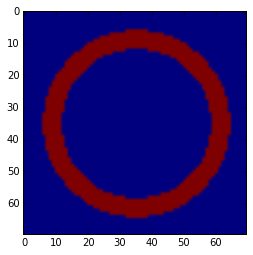

In [29]:
plt.imshow( roiOff[:,:,35])

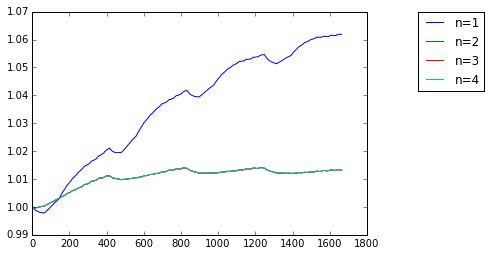

In [20]:
fgroups = ['1','2','3','4']
ngroups = len(fgroups)

nfociList=[]
avgRateRatio=[]
avgTempRatio=[]
ratioVsTime=[]
ratioVsNumber=[]
lesionVolCurvesON=[]
lesionVolCurvesOFF=[]

for gnum in range(0,ngroups):
    group=fgroups[gnum]
    
    
    grouphandle = f["%s" % group]
    t = grouphandle["TonCurve"].attrs['tstops']
    Ton = grouphandle["TonCurve"].value
    Toff =  grouphandle["ToffCurve"].value
    nf = grouphandle["CEM"].attrs['nfoc']
    nfociList.append(nf)
    #ratioVsTime.append(np.mean(Ton)/np.mean(Toff))
    
    avgRateRatio.append(Ton[-1]/Toff[-1])
    avgTempRatio.append(np.mean(Ton)/np.mean(Toff))
    plt.plot(t, Ton/Toff)
    
    (npasstot,nt,nx,ny,nz)=grouphandle["CEM"].value.shape

    npass=grouphandle["CEM"].attrs['passes']
    cem=grouphandle["CEM"].value[0:npass].reshape([npass*nt,nx,ny,nz])

    
    voxAboveCEMThreshON = np.zeros(npass*nt)
    voxAboveCEMThreshOFF = np.zeros(npass*nt)

    for a in range(0,npass*nt):
        voxAboveCEMThreshON[a] = voxelVol_ml*np.sum( cem[a][roiOn] > 240 )
        voxAboveCEMThreshOFF[a] = voxelVol_ml*np.sum( cem[a][roiOff] > 240 )
    
    ratioVsNumber.append(voxAboveCEMThreshON[-1]/voxAboveCEMThreshOFF[-1])
    lesionVolCurvesON.append(voxAboveCEMThreshON)
    lesionVolCurvesOFF.append(voxAboveCEMThreshOFF)
    

plt.legend(list(map(lambda x: 'n=%d' % (x), nfociList  )), bbox_to_anchor=(1.35, 1), borderaxespad=0.)

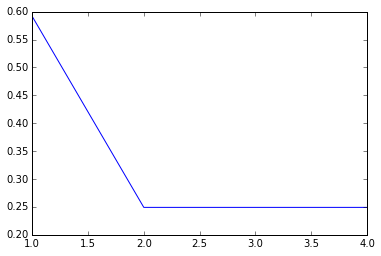

In [21]:
plt.plot(nfociList, ratioVsNumber )

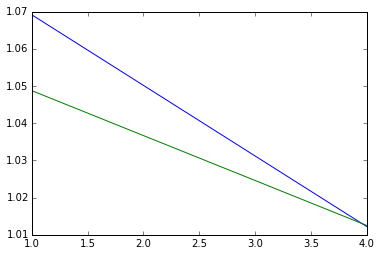

In [8]:
plt.plot(nfociList, avgRateRatio)
plt.plot(nfociList, avgTempRatio)

In [17]:
voxAboveCEMThreshON / (voxAboveCEMThreshOFF+1)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

C:\Users\Vandiver\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in true_divide


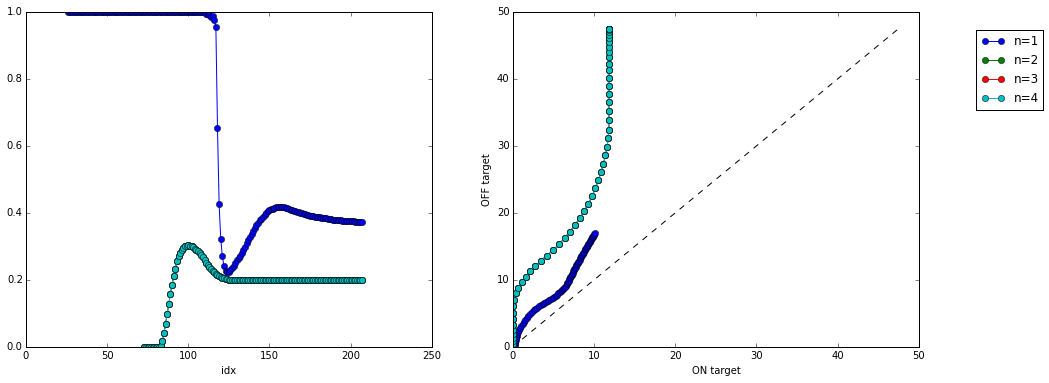

In [25]:

plt.figure(figsize=(16,6))
ax1=plt.subplot(121)
ax2=plt.subplot(122)
#ax3=plt.subplot(123)

avgVolRatio=[]
avgVolRateRatio=[]
avgVolRate=[]

maxvol=np.max([lesionVolCurvesOFF,lesionVolCurvesON])
ax2.plot(np.linspace(0,maxvol,1000),np.linspace(0,maxvol,1000), 'k--')

for gi in range(0,ngroups):
    onVolFractionvstime = lesionVolCurvesON[gi] / (lesionVolCurvesON[gi] + lesionVolCurvesOFF[gi])
    pl=ax1.plot(onVolFractionvstime, '-o')
    color=plt.getp( pl[0], 'color')
    
    #ax2.plot(lesionVolCurvesON[gi],  color=color  )
    #ax2.plot(lesionVolCurvesOFF[gi], '-.', color=color )
    #ax2.loglog([0,7000],[0,7000], 'k--')
    ax2.plot(lesionVolCurvesON[gi], lesionVolCurvesOFF[gi],  '-o', color=color, label='n=%d' % (nfociList[gi])  )
    avgVolRateRatio.append( onVolFractionvstime[-1] )
    avgVolRatio.append( np.max(lesionVolCurvesON[gi]) / np.max(lesionVolCurvesON[gi] + lesionVolCurvesOFF[gi]) )
    avgVolRate.append( lesionVolCurvesON[gi][-1] )

    
#ax2.set_xlim([0,3000])
#ax2.set_ylim([0,3000])

ax1.set_xlabel('idx')
ax2.set_xlabel('ON target')
ax2.set_ylabel('OFF target')
ax2.legend(bbox_to_anchor=(1.35, 1), borderaxespad=1.5)

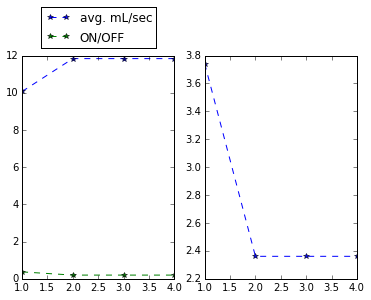

In [26]:
plt.subplot(121)
plt.plot(nfociList, np.array(avgVolRate),'--*' )
plt.plot(nfociList, np.multiply(1,avgVolRateRatio),'--*')
plt.legend(['avg. mL/sec', 'ON/OFF'], bbox_to_anchor=(1, 1.3), borderaxespad=1.5)
plt.subplot(122)
plt.plot(nfociList, avgVolRateRatio*np.array(avgVolRate), '--*' )

8.7500000000000236e-10

In [261]:
np.max([lesionVolCurvesOFF,lesionVolCurvesON])

6965.0

C:\Users\Vandiver\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


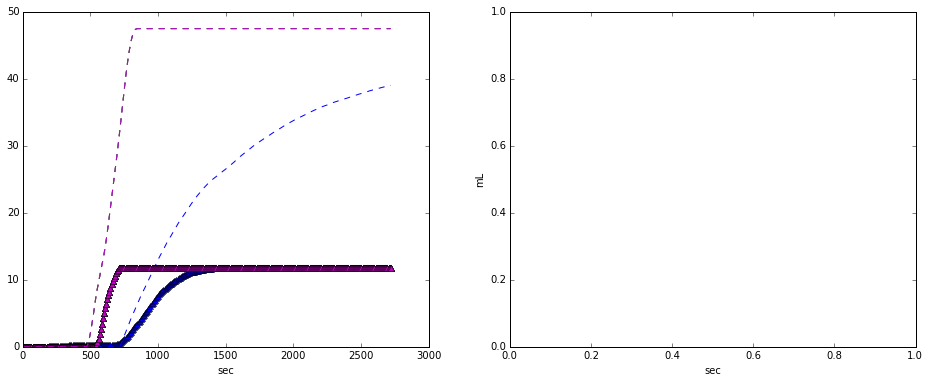

In [30]:
plt.figure(figsize=(16,6))
ax1=plt.subplot(121)
ax2=plt.subplot(122)

for gi in range(0,ngroups):
    pl=ax1.plot(t, lesionVolCurvesON[gi], '-^', label='n=%d' % (nfociList[gi]))
    color=plt.getp( pl[0], 'color')
    ax1.plot(t, lesionVolCurvesOFF[gi],  '--', color=color, label='n=%d' % (nfociList[gi])  )
    

ax1.set_xlabel('sec')
ax2.set_xlabel('sec')
ax2.set_ylabel('mL')
ax2.legend(bbox_to_anchor=(1.35, 1), borderaxespad=1.5)


[[<matplotlib.lines.Line2D at 0x1bfeb198>],

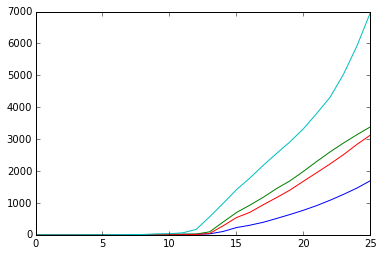

In [180]:
list(map(plt.plot,lesionVolCurvesOFF))

In [155]:
npass=f["2/CEM"].attrs['passes']
cem=f["2/CEM"].value[0:npass].reshape([npass*nt,nx,ny,nz])

voxAboveCEMThresh = np.zeros(npass*nt)

for a in range(0,npass*nt):
    voxAboveCEMThresh[a] = np.sum( cem[a] > 240 )

In [156]:
for a in range(0,npass*nt):
    voxAboveCEMThresh[a] = np.sum( cem[a] > 240 )

In [157]:
voxAboveCEMThresh

array([   14.,    29.,    52.,    55.,    93.,   149.,   185.,   212.,
         233.,   276.,   349.,   397.,   450.,   746.,  1250.,  1744.,
        2164.,  2529.,  2967.,  3374.,  3868.,  4398.,  4900.,  5342.,
        5897.,  6908.])

In [154]:
voxAboveCEMThresh

array([   13.,    34.,    60.,    80.,   111.,   139.,   166.,   201.,
         238.,   278.,   311.,   345.,   392.,   478.,   704.,   986.,
        1157.,  1375.,  1616.,  1875.,  2132.,  2419.,  2698.,  3000.,
        3325.,  3673.])

In [144]:
np.max(f["2/CEM"].value[1])

8.6264879131445617e+21

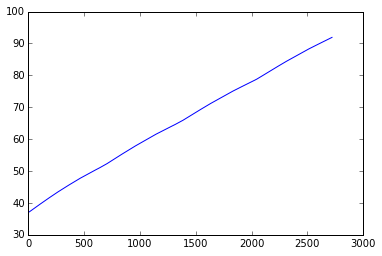

In [10]:
grouphandle = f["2"]
t = grouphandle["TonCurve"].attrs['tstops']
Ton = grouphandle["TonCurve"].value
Toff =  grouphandle["ToffCurve"].value
nf = grouphandle["CEM"].attrs['nfoc']
nfociList.append(nf)
    #ratioVsTime.append(np.mean(Ton)/np.mean(Toff))
    
avgRateRatio.append(Ton[-1]/Toff[-1])
avgTempRatio.append(np.mean(Ton)/np.mean(Toff))
plt.plot(t, Ton)
    
(npasstot,nt,nx,ny,nz)=grouphandle["CEM"].value.shape

npass=grouphandle["CEM"].attrs['passes']
cem=grouphandle["CEM"].value[0:npass].reshape([npass*nt,nx,ny,nz])

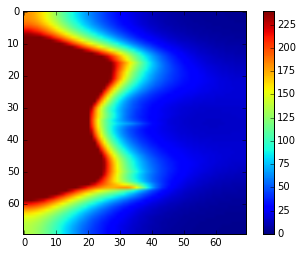

In [56]:
im1=plt.imshow( f["4/CEM"].value[1,0,:,35,:], vmin=0, vmax=240)
cb1=plt.colorbar(mappable=im1, orientation='vertical')

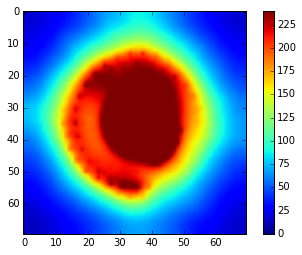

In [55]:
im1=plt.imshow( f["4/CEM"].value[1,15,:,:,foczidx], vmin=0, vmax=240)
cb1=plt.colorbar(mappable=im1, orientation='vertical')

In [ ]:
passnum=0


n=-1

fig=plt.figure(figsize=(19,7))
ax1=fig.add_subplot(141)

colormap = image.cm.hot

im1=ax1.imshow(np.transpose(Tmax1passFinal[passnum][:,:,focplaneZpix]), vmin=T0,vmax=T0+20, cmap=colormap, origin='lower', 
               extent=[100*xrp[0], 100*xrp[-1], 100*yrp[0], 100*yrp[-1]], interpolation="none")
ax1.plot(100*xdcPoints[:,0], 100*xdcPoints[:,1], 'b--*')


ax2=fig.add_subplot(142)
im2=ax2.imshow(np.transpose(Tmax1passFinal[passnum][:,floor(Ny/2),:]), vmin=T0,vmax=T0+20, cmap=colormap, origin='lower', 
               extent=[100*xrp[0], 100*xrp[-1], 100*zrp[0], 100*zrp[-1]], interpolation="none")

ax3=fig.add_subplot(143)
im3=ax3.imshow(np.transpose(CEM1vsTimevsPass[passnum][n, :,:,focplaneZpix]), vmin=0,vmax=240, cmap=colormap, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*yrp[0], 100*yrp[-1]])
ax3.plot(100*xdcPoints[:,0], 100*xdcPoints[:,1], 'b--*')
ax4=fig.add_subplot(144)
im4=ax4.imshow(np.transpose(CEM1vsTimevsPass[passnum][n, :,floor(Ny/2),:]), vmin=0,vmax=240, cmap=colormap, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*zrp[0], 100*zrp[-1]])


cb1=plt.colorbar(mappable=im1, ax=ax1, orientation='vertical')
cb2=plt.colorbar(mappable=im2, ax=ax2, orientation='vertical')
cb3=plt.colorbar(mappable=im3, ax=ax3, orientation='horizontal')
cb4=plt.colorbar(mappable=im4, ax=ax4, orientation='horizontal')
cb1.set_label('C')
cb2.set_label('C')
cb3.set_label('CEM')
cb4.set_label('CEM')